# Torneo SNA 2025

* Nombre equipo:
  * 3DIC
* Participantes:
  * Paula Corral rebollar
  * Lucía Cuevas Serrano

# Instalar dependencias

In [1]:
!pip install torch_geometric

#!pip install torch-scatter -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)")+.html
import warnings
warnings.filterwarnings("ignore", message="The usage of `scatter")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.0 MB/s eta 0:00:00


# Cargar el dataset

In [2]:
import json
import networkx as nx
import os
import os.path as osp
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset, download_url
from torch_geometric.utils.convert import from_networkx
from zipfile import ZipFile

class TournamentDataset(InMemoryDataset):

    TORUNAMENT_URL = 'https://drive.upm.es/s/WTBtQ3HH2GjpGAi/download'

    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)
        self.train_idx = torch.load(self.processed_paths[1], weights_only=False)
        self.test_idx = torch.load(self.processed_paths[2], weights_only=False)

    @property
    def raw_file_names(self):
        return ['nx_graphs.zip']

    @property
    def processed_file_names(self):
        return ['geometric_data_processed.pt', "train_idx.pt", "test_idx.pt"]

    @property
    def num_classes(self):
        return 1

    @property
    def num_features(self):
        return 9

    def download(self):
        download_url(self.TORUNAMENT_URL, self.raw_dir, filename='nx_graphs.zip')

    def process(self):

        with ZipFile(self.raw_paths[0], 'r') as zip_ref:
            zip_ref.extractall(self.raw_dir)

        data_list = []
        train_idx = []
        test_idx = []
        for f in os.listdir(osp.join(self.raw_dir, "nx_graphs")):
            G = nx.read_gml(osp.join(self.raw_dir, "nx_graphs", f))
            data = from_networkx(G)
            data.x = data.x.float()

            data.nid = torch.tensor([G.graph["molecule_id"]], dtype=torch.long)
            data_list.append(data)

            if G.graph["set"] == "training":
                data.y = torch.tensor([G.graph["y"]], dtype=torch.float)
                train_idx.append(G.graph["molecule_id"])
            else:
                data.y = torch.tensor([torch.nan], dtype=torch.float)
                test_idx.append(G.graph["molecule_id"])

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data_list.sort(key=lambda x: x.nid.item())

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        torch.save(train_idx, self.processed_paths[1])
        torch.save(test_idx, self.processed_paths[2])

Processing...
Done!


Number of molecules: 4200
Number of node attributes: 9
Example Graph: Data(x=[22, 9], edge_index=[2, 50], y=[1], molecule_id=[1], set='training', nid=[1])
Training set size: 3360
Test set size: 840
Trainning distribution: count    3360.000000
mean        2.200554
std         1.199276
min        -1.500000
25%         1.437500
50%         2.360000
75%         3.100000
max         4.500000
dtype: float64
Test distribution: Counter({'nan': 840})


Text(0.5, 1.0, 'Histogram of training labels')

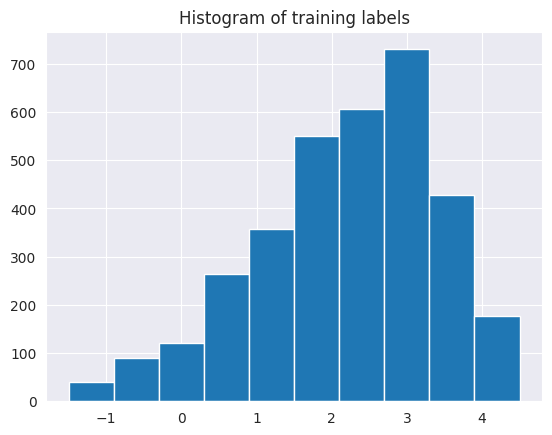

In [3]:
from collections import Counter
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

dataset = TournamentDataset(root='tournament')

print(f"Number of molecules: {len(dataset)}")
print(f"Number of node attributes: {dataset.num_features}")
print(f"Example Graph: {dataset[0]}")
print(f"Training set size: {len(dataset.train_idx)}")
print(f"Test set size: {len(dataset.test_idx)}")
print(f"Trainning distribution: {pd.Series([dataset[i].y.item() for i in dataset.train_idx]).describe()}")
print(f"Test distribution: {Counter([str(dataset[i].y.item()) for i in dataset.test_idx])}")

pd.Series([dataset[i].y.item() for i in dataset.train_idx]).hist()
plt.title("Histogram of training labels")

# Dividir datos

In [4]:
'''import pandas as pd
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(dataset.train_idx, test_size=0.15)

train_loader = DataLoader(dataset[train_idx], batch_size=512, shuffle=True)
val_loader = DataLoader(dataset[val_idx], batch_size=len(val_idx))

print(f"Number of training graphs: {len(train_idx)}, labels {pd.Series([dataset[i].y.item() for i in train_idx]).describe()}")
print(f"Number of validation graphs: {len(val_idx)}, labels {pd.Series([dataset[i].y.item() for i in val_idx]).describe()}")'''

'import pandas as pd\nfrom torch_geometric.loader import DataLoader\nfrom sklearn.model_selection import train_test_split\n\ntrain_idx, val_idx = train_test_split(dataset.train_idx, test_size=0.15)\n\ntrain_loader = DataLoader(dataset[train_idx], batch_size=512, shuffle=True)\nval_loader = DataLoader(dataset[val_idx], batch_size=len(val_idx))\n\nprint(f"Number of training graphs: {len(train_idx)}, labels {pd.Series([dataset[i].y.item() for i in train_idx]).describe()}")\nprint(f"Number of validation graphs: {len(val_idx)}, labels {pd.Series([dataset[i].y.item() for i in val_idx]).describe()}")'

![](split_previo.png)

In [5]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Extraer índices y etiquetas

train_indices = np.array(dataset.train_idx)
y_values = np.array([dataset[i].y.item() for i in train_indices])

# Crear bins para stratify

n_bins = 10 
bins = pd.qcut(y_values, q=n_bins, duplicates='drop', labels=False)

# Split

train_idx, val_idx = train_test_split(train_indices, test_size=0.15, stratify=bins, random_state=42)

# Aplicar a train

train_df = pd.DataFrame({"idx": train_idx, "y": [dataset[i].y.item() for i in train_idx]})
train_df["bin"] = pd.qcut(train_df["y"], q=n_bins, duplicates='drop')
max_bin_size = train_df["bin"].value_counts().max()

oversampled_dfs = []

for _, group in train_df.groupby("bin"):
    if len(group) < max_bin_size:
        group_upsampled = resample(group, replace=True, n_samples=max_bin_size, random_state=42)
        oversampled_dfs.append(group_upsampled)
    else:
        oversampled_dfs.append(group)

train_df_balanced = pd.concat(oversampled_dfs)
oversampled_train_idx = train_df_balanced["idx"].values

# Data Loaders

train_loader = DataLoader(dataset[oversampled_train_idx], batch_size=256, shuffle=True)
val_loader = DataLoader(dataset[val_idx], batch_size=len(val_idx), shuffle=False)

# Revisar 

print("Train (oversampled):")
print(pd.Series([dataset[i].y.item() for i in oversampled_train_idx]).describe())

print("\Validation:")
print(pd.Series([dataset[i].y.item() for i in val_idx]).describe())


<>:50: SyntaxWarning: invalid escape sequence '\V'
<>:50: SyntaxWarning: invalid escape sequence '\V'
/tmp/ipython-input-236521219.py:50: SyntaxWarning: invalid escape sequence '\V'
  print("\Validation:")


Train (oversampled):
count    3050.000000
mean        2.203997
std         1.193095
min        -1.480000
25%         1.440000
50%         2.365000
75%         3.100000
max         4.500000
dtype: float64
\Validation:
count    504.000000
mean       2.198948
std        1.212891
min       -1.420000
25%        1.407500
50%        2.365000
75%        3.140000
max        4.500000
dtype: float64


/tmp/ipython-input-236521219.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, group in train_df.groupby("bin"):


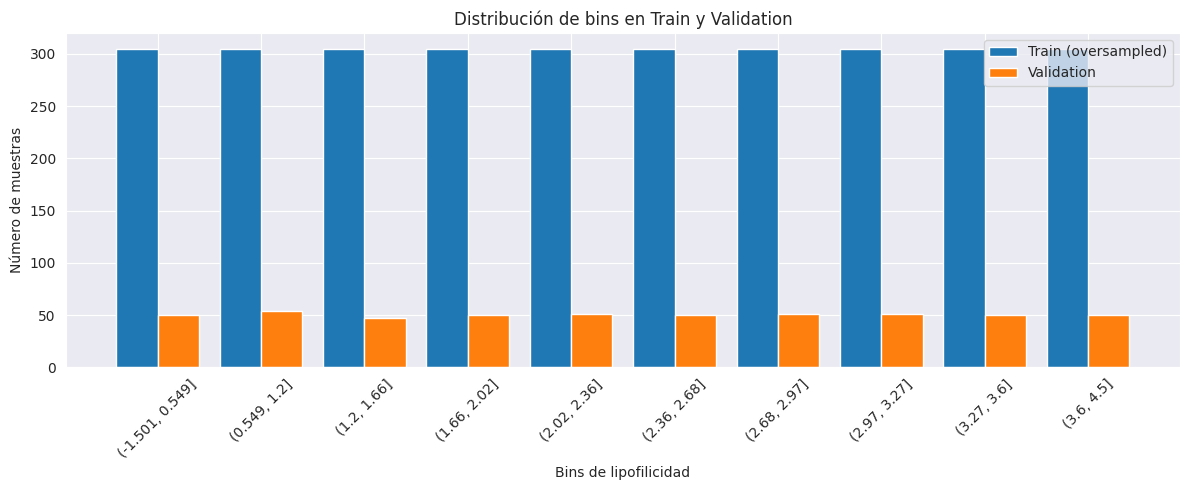

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

all_y = np.array([dataset[i].y.item() for i in dataset.train_idx])
bin_edges = pd.qcut(all_y, q=n_bins, duplicates='drop', retbins=True)[1]

# Train
train_y = np.array([dataset[i].y.item() for i in oversampled_train_idx])
train_bins = pd.cut(train_y, bins=bin_edges, include_lowest=True)
train_counts = train_bins.value_counts().sort_index()

# Validation
val_y = np.array([dataset[i].y.item() for i in val_idx])
val_bins = pd.cut(val_y, bins=bin_edges, include_lowest=True)
val_counts = val_bins.value_counts().sort_index()

# Barplot
x = np.arange(len(train_counts))
width = 0.4

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, train_counts.values, width, label="Train (oversampled)")
plt.bar(x + width/2, val_counts.values, width, label="Validation")

plt.xticks(x, [str(interval) for interval in train_counts.index], rotation=45)
plt.xlabel("Bins de lipofilicidad")
plt.ylabel("Número de muestras")
plt.title("Distribución de bins en Train y Validation")
plt.legend()
plt.tight_layout()
plt.show()


# Definir modelo

In [ ]:
'''from torch.nn import Module
from torch_geometric.nn import GCN, MLP, global_add_pool

class GCNGraph(Module):

    def __init__(self, num_features, num_classes, hidden_channels=64, n_layers=3):
        super(GCNGraph, self).__init__()
        self.gcn = GCN(
            in_channels=num_features,
            hidden_channels=hidden_channels,
            num_layers=n_layers,
            out_channels=hidden_channels,
            dropout=0.5
        )
        self.cls = MLP(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            out_channels=num_classes,
            num_layers=2,
            dropout=0.5
        )

    def reset_parameters(self):
        self.gcn.reset_parameters()
        self.cls.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.gcn(x.float(), edge_index)
        x = global_add_pool(x, batch)
        x = self.cls(x)
        return x'''

'from torch.nn import Module\nfrom torch_geometric.nn import GCN, MLP, global_add_pool\n\nclass GCNGraph(Module):\n\n    def __init__(self, num_features, num_classes, hidden_channels=64, n_layers=3):\n        super(GCNGraph, self).__init__()\n        self.gcn = GCN(\n            in_channels=num_features,\n            hidden_channels=hidden_channels,\n            num_layers=n_layers,\n            out_channels=hidden_channels,\n            dropout=0.5\n        )\n        self.cls = MLP(\n            in_channels=hidden_channels,\n            hidden_channels=hidden_channels,\n            out_channels=num_classes,\n            num_layers=2,\n            dropout=0.5\n        )\n\n    def reset_parameters(self):\n        self.gcn.reset_parameters()\n        self.cls.reset_parameters()\n\n    def forward(self, data):\n        x, edge_index, batch = data.x, data.edge_index, data.batch\n\n        x = self.gcn(x.float(), edge_index)\n        x = global_add_pool(x, batch)\n        x = self.cls(x)\

In [8]:
from torch.nn import Module
from torch_geometric.nn import GCN, MLP, global_add_pool, GCNConv, global_max_pool, BatchNorm

class GCNGraph(Module):

    def __init__(self, num_features, num_classes, hidden_channels=128, n_layers=4, dropout=0.3):
        super(GCNGraph, self).__init__()

        # Proyección inicial (proyectar las 9 features a un espacio latente común)
        self.input_proj = torch.nn.Linear(num_features, hidden_channels)

        # GCN explícito por capas
        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()

        for _ in range(n_layers):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.norms.append(BatchNorm(hidden_channels))

        # Pooling múltiple
        self.pool_dim = hidden_channels * 2

        # MLP profundo
        self.regressor = torch.nn.Sequential(
            torch.nn.Linear(self.pool_dim, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(hidden_channels),
            torch.nn.Dropout(dropout),

            torch.nn.Linear(hidden_channels, hidden_channels // 2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(hidden_channels // 2),
            torch.nn.Dropout(dropout),

            torch.nn.Linear(hidden_channels // 2, num_classes)
        )

        self.dropout = dropout


    def reset_parameters(self):
        self.input_proj.reset_parameters()
        for conv, norm in zip(self.convs, self.norms):
            conv.reset_parameters()
            norm.reset_parameters()
        for m in self.regressor:
            if hasattr(m, "reset_parameters"):
                m.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Proyección inicial
        x = self.input_proj(x)

        # GCN profundo con residual
        for conv, norm in zip(self.convs, self.norms):
            h = conv(x, edge_index)
            h = norm(h)
            h = torch.relu(h)
            h = torch.nn.functional.dropout(h, p=self.dropout, training=self.training)
            x = x + h  

        # Pooling

        x = torch.cat([
            global_add_pool(x, batch),
            global_max_pool(x, batch)
        ], dim=1)

        # Regresión

        out = self.regressor(x)
        return out


# Entrenar el modelo

In [9]:
'''import torch

def train():
  model.train()
  total_loss = 0

  for data in train_loader:
    data = data.to(device)
    optimizer.zero_grad()

    y_true = data.y.view(-1)
    y_pred = model(data).view(-1)

    loss = criterion(y_pred, y_true)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  return total_loss / len(train_loader)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = GCNGraph(dataset.num_features, 1)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.HuberLoss()

for epoch in range(501):
    train_loss = train()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}')'''

'import torch\n\ndef train():\n  model.train()\n  total_loss = 0\n\n  for data in train_loader:\n    data = data.to(device)\n    optimizer.zero_grad()\n\n    y_true = data.y.view(-1)\n    y_pred = model(data).view(-1)\n\n    loss = criterion(y_pred, y_true)\n    loss.backward()\n    optimizer.step()\n    total_loss += loss.item()\n\n  return total_loss / len(train_loader)\n\ndevice = "cuda" if torch.cuda.is_available() else "cpu"\n\nmodel = GCNGraph(dataset.num_features, 1)\nmodel = model.to(device)\n\noptimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)\ncriterion = torch.nn.HuberLoss()\n\nfor epoch in range(501):\n    train_loss = train()\n    if epoch % 10 == 0:\n        print(f\'Epoch: {epoch}, Train Loss: {train_loss:.4f}\')'

In [10]:
import torch
from sklearn.metrics import root_mean_squared_error

def train_epoch():
  model.train()
  total_loss = 0.0

  y_true_all = []
  y_pred_all = []

  for data in train_loader:
    data = data.to(device)
    optimizer.zero_grad()

    y_true = data.y.view(-1)
    y_pred = model(data).view(-1)

    loss = criterion(y_pred, y_true)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

    y_true_all.extend(y_true.detach().cpu().numpy())
    y_pred_all.extend(y_pred.detach().cpu().numpy())

  avg_loss = total_loss / len(train_loader)
  rmse = root_mean_squared_error(y_true_all, y_pred_all)

  return avg_loss, rmse


def validate_epoch():
    model.eval()
    total_loss = 0.0

    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)

            y_true = data.y.view(-1)
            y_pred = model(data).view(-1)

            loss = criterion(y_pred, y_true)
            total_loss += loss.item()

            y_true_all.extend(y_true.cpu().numpy())
            y_pred_all.extend(y_pred.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    rmse = root_mean_squared_error(y_true_all, y_pred_all)

    return avg_loss, rmse

device = "cuda" if torch.cuda.is_available() else "cpu"

model = GCNGraph(dataset.num_features, 1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.HuberLoss()

num_epochs=1001
train_losses = []
train_rmses = []
val_losses = []
val_rmses = []

# Criterio de parada
patience = 250
best_val_rmse = float('inf')
epochs_no_improve = 0

# Entrenar

for epoch in range(num_epochs):
    train_loss, train_rmse = train_epoch()
    val_loss, val_rmse = validate_epoch()

    train_losses.append(train_loss)
    train_rmses.append(train_rmse)
    val_losses.append(val_loss)
    val_rmses.append(val_rmse)

    if epoch % 10 == 0:
        print(
            f"Epoch {epoch:03d} | "
            f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}")
        
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch}")
        model.load_state_dict(best_model_state) 
        break


Epoch 000 | Train Loss: 1.7594, Train RMSE: 2.5141 | Val Loss: 0.8420, Val RMSE: 1.5123
Epoch 010 | Train Loss: 0.8856, Train RMSE: 1.5905 | Val Loss: 1.3160, Val RMSE: 2.0380
Epoch 020 | Train Loss: 0.5754, Train RMSE: 1.2333 | Val Loss: 0.4357, Val RMSE: 1.0335
Epoch 030 | Train Loss: 0.4963, Train RMSE: 1.1143 | Val Loss: 0.4519, Val RMSE: 1.0623
Epoch 040 | Train Loss: 0.4436, Train RMSE: 1.0462 | Val Loss: 0.3525, Val RMSE: 0.9017
Epoch 050 | Train Loss: 0.4040, Train RMSE: 0.9824 | Val Loss: 0.6399, Val RMSE: 1.3238
Epoch 060 | Train Loss: 0.3616, Train RMSE: 0.9163 | Val Loss: 0.6058, Val RMSE: 1.2254
Epoch 070 | Train Loss: 0.3477, Train RMSE: 0.8965 | Val Loss: 0.5187, Val RMSE: 1.1537
Epoch 080 | Train Loss: 0.3235, Train RMSE: 0.8553 | Val Loss: 0.3151, Val RMSE: 0.8559
Epoch 090 | Train Loss: 0.3228, Train RMSE: 0.8562 | Val Loss: 0.3424, Val RMSE: 0.8843
Epoch 100 | Train Loss: 0.3028, Train RMSE: 0.8300 | Val Loss: 0.5649, Val RMSE: 1.1631
Epoch 110 | Train Loss: 0.2766, 

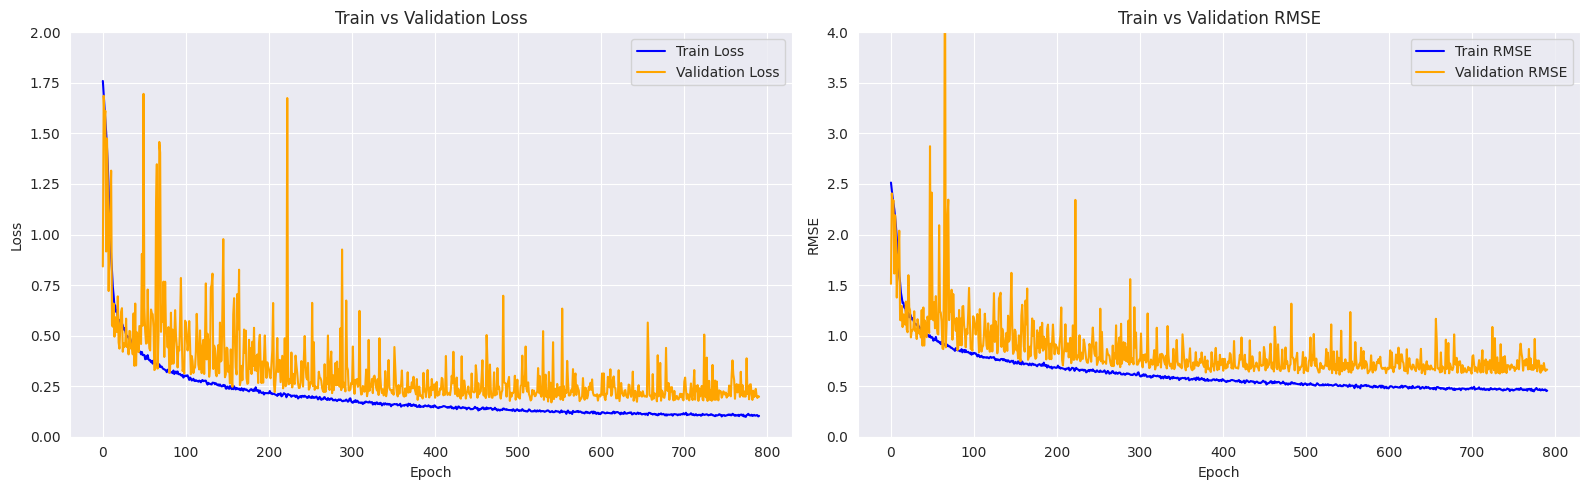

In [11]:
import numpy as np
import matplotlib.pyplot as plt

epochs = range(len(train_losses))
fig, axes = plt.subplots(1, 2, figsize=(16, 5)) 

# Loss
axes[0].plot(epochs, train_losses, label="Train Loss", color="blue")
axes[0].plot(epochs, val_losses, label="Validation Loss", color="orange")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Train vs Validation Loss")
axes[0].set_ylim([0, 2])  
axes[0].legend()
axes[0].grid(True)

# RMSE
axes[1].plot(epochs, train_rmses, label="Train RMSE", color="blue")
axes[1].plot(epochs, val_rmses, label="Validation RMSE", color="orange")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("RMSE")
axes[1].set_title("Train vs Validation RMSE")
axes[1].set_ylim([0, 4])  
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


# Validación

In [12]:
'''import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

def test():
    model.eval()

    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)

            out = model(data)
            y_hat = out.view(-1)

            y_pred.extend(y_hat.cpu().tolist())
            y_true.extend(data.y.tolist())
    return y_true, y_pred

y_true, y_pred = test()
print(f"RMSE: {root_mean_squared_error(y_true, y_pred)}")

def plot_residual_heatmap(y_true, y_pred, n_bins=20):
    residuals = y_pred - y_true

    plt.figure()
    plt.hist2d(y_true, residuals, bins=n_bins)
    plt.colorbar(label="Count")
    plt.xlabel("True value")
    plt.ylabel("Residual (Pred - True)")
    plt.title("Residual Heatmap")
    plt.show()

def plot_true_vs_pred(y_true, y_pred):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel("True value")
    plt.ylabel("Predicted value")
    plt.title("True vs Predicted Values")
    plt.show()

plot_true_vs_pred(np.array(y_true).flatten(), np.array(y_pred).flatten())
plot_residual_heatmap(np.array(y_true).flatten(), np.array(y_pred).flatten(), n_bins=20)'''



'import numpy as np\nimport seaborn as sns\nimport matplotlib.pyplot as plt\nfrom sklearn.metrics import root_mean_squared_error\n\ndef test():\n    model.eval()\n\n    y_pred = []\n    y_true = []\n    with torch.no_grad():\n        for data in val_loader:\n            data = data.to(device)\n\n            out = model(data)\n            y_hat = out.view(-1)\n\n            y_pred.extend(y_hat.cpu().tolist())\n            y_true.extend(data.y.tolist())\n    return y_true, y_pred\n\ny_true, y_pred = test()\nprint(f"RMSE: {root_mean_squared_error(y_true, y_pred)}")\n\ndef plot_residual_heatmap(y_true, y_pred, n_bins=20):\n    residuals = y_pred - y_true\n\n    plt.figure()\n    plt.hist2d(y_true, residuals, bins=n_bins)\n    plt.colorbar(label="Count")\n    plt.xlabel("True value")\n    plt.ylabel("Residual (Pred - True)")\n    plt.title("Residual Heatmap")\n    plt.show()\n\ndef plot_true_vs_pred(y_true, y_pred):\n    plt.figure()\n    plt.scatter(y_true, y_pred, alpha=0.5)\n    plt.plot

RMSE: 0.6635597870564752


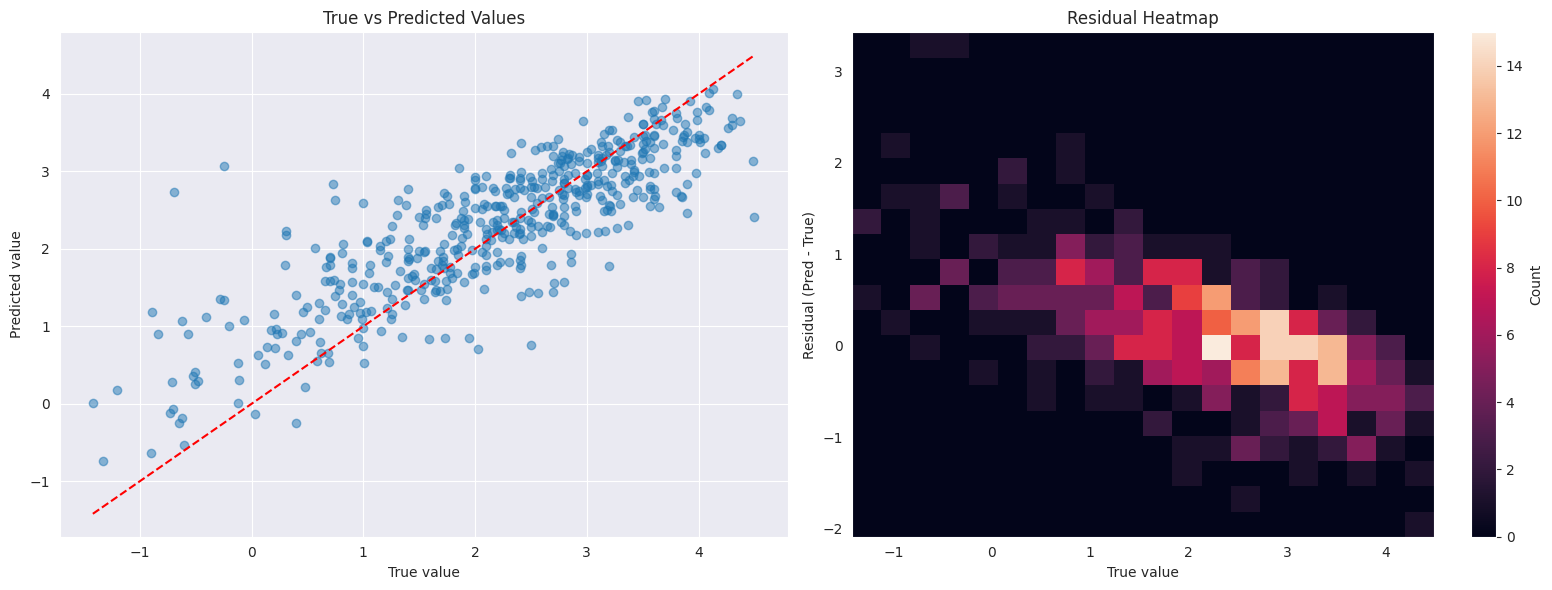

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

model.load_state_dict(best_model_state)

def test():
    model.eval()

    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)

            out = model(data)
            y_hat = out.view(-1)

            y_pred.extend(y_hat.cpu().tolist())
            y_true.extend(data.y.tolist())
    return y_true, y_pred

y_true, y_pred = test()
print(f"RMSE: {root_mean_squared_error(y_true, y_pred)}")

epochs_data = np.array(y_true).flatten()
pred_data = np.array(y_pred).flatten()

def print_figures(epochs_data, pred_data):

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].scatter(epochs_data, pred_data, alpha=0.5)
    axes[0].plot([min(epochs_data), max(epochs_data)], [min(epochs_data), max(epochs_data)], color='red', linestyle='--')
    axes[0].set_xlabel("True value")
    axes[0].set_ylabel("Predicted value")
    axes[0].set_title("True vs Predicted Values")
    axes[0].grid(True)

    residuals = pred_data - epochs_data
    hb = axes[1].hist2d(epochs_data, residuals, bins=20)
    plt.colorbar(hb[3], ax=axes[1], label="Count")
    axes[1].set_xlabel("True value")
    axes[1].set_ylabel("Residual (Pred - True)")
    axes[1].set_title("Residual Heatmap")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

print_figures(epochs_data, pred_data)

# Test

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from google.colab import files

model.load_state_dict(best_model_state)
model.eval()

uploaded = files.upload()
test_labels_df = pd.read_csv("test_labels.csv")  
test_labels_dict = dict(zip(test_labels_df['id'], test_labels_df['label']))

y_true = []
y_pred = []

with torch.no_grad():
    for idx in dataset.test_idx: 
        data = dataset[idx]
        data = data.to(device)
        out = model(data)
        y_hat = out.view(-1).cpu().item()

        y_pred.append(y_hat)
        y_true.append(test_labels_dict[data.nid.item()])  

print(f"RMSE: {root_mean_squared_error(y_true, y_pred)}")

y_true_arr = np.array(y_true).flatten()
y_pred_arr = np.array(y_pred).flatten()

print_figures(y_true_arr, y_pred_arr)


KeyboardInterrupt: 